In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.optimize import root
from scipy.optimize import fsolve

## SN Curve Prediction - Reverse Engineering

### Data Generation from an SN Curve

In [36]:
def S_e(a,b, S_uts, S_100):
    S_a  = 0.5*(b - a)*S_100
    S_m  = 0.5*(b + a)*S_100
    S_e  = S_a/(1-S_m/S_uts)
    
    return S_e

In [3]:
s_100 = 210
S_100 = s_100**2 # Stress Parameter

### Reverse Engineering the process to estimate S_uts (Ultimate Tensile Strength)

In [75]:
a_ar = np.array([0.40, 0.70, 0.40, 0.33])**2
b_ar = np.array([1.00, 1.00, 0.80, 0.66])**2

N  = [131300, 915400, 8664200, 173210400 ]
l = len(N)


for i in range(l):
    Sa_temp = 0.5*(b_ar[i] - a_ar[i])*S_100
    Sm_temp = 0.5*(b_ar[i] + a_ar[i])*S_100
    Sa_ar = np.append(Sa_ar,Sa_temp)
    Sm_ar = np.append(Sm_ar,Sm_temp)

In [78]:
a_ar = np.array([0.40, 0.70, 0.40, 0.33, 0.3333, 0.5833])**2
b_ar = np.array([1.00, 1.00, 0.80, 0.66, 0.8333, 0.8333])**2

N = np.array([131300, 915400, 8664200, 173210400, 2403300, 37737400])
l = len(N)

Sa_ar = np.array([])
Sm_ar = np.array([])

for i in range(l):
    Sa_temp = 0.5*(b_ar[i] - a_ar[i])*S_100
    Sm_temp = 0.5*(b_ar[i] + a_ar[i])*S_100
    Sa_ar = np.append(Sa_ar,Sa_temp)
    Sm_ar = np.append(Sm_ar,Sm_temp)


In [14]:
print(b_ar)
print(a_ar)

[1.         1.         0.64       0.4356     0.69438889 0.69438889]
[0.16       0.49       0.16       0.1089     0.11108889 0.34023889]


In [80]:
S_uts_arr = np.array([])

Sm_new = np.array([ 0,0,0])
Sa_new = np.array([ 0,0,0 ])
N_new  = np.array([0,0,0])

for i in range(l-2):
    Sm_new[0] = Sm_ar[i]
    Sa_new[0] = Sa_ar[i]
    N_new[0] = N[i]
    for j in range(i+1,l-1):
        Sm_new[1] = Sm_ar[j]
        Sa_new[1] = Sa_ar[j]
        N_new[1] = N[j]
        for k in range(j+1,l):
            Sm_new[2] = Sm_ar[k]
            Sa_new[2] = Sa_ar[k]
            N_new[2] = N[k]

            c1 = np.around( np.log(N_new[1]/N_new[0])/np.log(N_new[2]/N_new[0]) , decimals = 4)

            c2 = np.around( (Sa_new[2]**c1)/(Sa_new[1]*Sa_new[0]**(c1-1)) , decimals = 4)

            c3 = np.around( (Sm_new[2]**c1)/(Sm_new[1]*Sm_new[0]**(c1-1)) , decimals = 4)
            
            r = root(lambda d: (d/Sm_new[2] -1)**c1 - (c2/c3)*(d/Sm_new[1] -1)*(d/Sm_new[0] -1)**(c1-1), S_100)

            print(i,j,k,r.x[0])
            
            S_uts_arr = np.append(r.x[0],S_uts_arr)


S_uts_est = np.mean(S_uts_arr)
print(S_100, S_uts_est)

0 1 2 72753.28380184698
0 1 3 71276.13595518151
0 1 4 75389.89622587996
0 1 5 69360.8253660333
0 2 3 102670.78717697812
0 2 4 120116.52280885864
0 2 5 94779.95782375366
0 3 4 44100.0
0 3 5 83316.53630753716
0 4 5 102467.57326654078
1 2 3 76976.85630222897
1 2 4 44100.0
1 2 5 81121.59139911016
1 3 4 33637.1616042642
1 3 5 44100.0
1 4 5 79702.38694819155
2 3 4 90827.62511565484
2 3 5 44100.0
2 4 5 86119.92395681769
3 4 5 23582.15292721949
44100 72024.96084930483


/home/shriram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in power


### Reverse Engineering the process to estimate m (slope of sn curve)

In [136]:
S_uts_est = 72300

In [137]:
m_est_ar = np.array([])

for i in range(l-1):
    
    Se1 = S_e(a_ar[i], b_ar[i], S_uts_est, S_100)
    N1 = N[i]
    
    for j in range(i+1,l,1):
        
            Se2 = S_e(a_ar[j], b_ar[j], S_uts_est, S_100)
            N2 = N[j]
            
            m_temp = (np.log(N2/N1))/(np.log(Se1/Se2))
            
            m_est_ar = np.append(m_est_ar, m_temp)
            
m_est = np.round( np.mean(m_est_ar),2)     

print(m_est)

6.08


### Reverse Engineering the process to estimate k in NS^m = k

In [138]:
k_est_arr = np.array([])

for i in range(l):
    Se = S_e(a_ar[i], b_ar[i], S_uts_est, S_100)
    k_temp = N[i]*(Se**m_est)
    
    k_est_arr = np.append(k_est_arr, k_temp)

k_est = np.mean(k_est_arr)

print(k_est)

1.5232187691387314e+32


### Verification of results

In [139]:
a_ver = np.array([0.40, 0.70, 0.40, 0.33, 0.3333, 0.5833])**2
b_ver = np.array([1.00, 1.00, 0.80, 0.66, 0.8333, 0.8333])**2

N_ver = np.array([131300, 915400, 8664200, 173210400, 2403300, 37737400])

In [140]:
N_pred = np.array([])
Se_ver_arr = np.array([])

for i in range(6):
    Se_ver = S_e(a_ver[i], b_ver[i], S_uts_est, S_100)
    Se_ver_arr = np.append(Se_ver_arr, Se_ver)
    Sem = Se_ver**m_est
    N_pred_temp = k_est/Sem
    N_pred = np.append(N_pred,N_pred_temp)

error = 100*(N_pred/N_ver-1)
print(N_ver)
print(N_pred)
print(error)

[   131300    915400   8664200 173210400   2403300  37737400]
[1.20878591e+05 8.97253381e+05 9.42674579e+06 1.77544450e+08
 2.84343937e+06 3.27111513e+07]
[ -7.93709733  -1.9823704    8.8011102    2.50218804  18.31395875
 -13.31901164]


### Plots 

In [141]:
print(np.log(N))

[11.78524006 13.72711641 15.97471015 18.9700176  14.69235335 17.4461622 ]


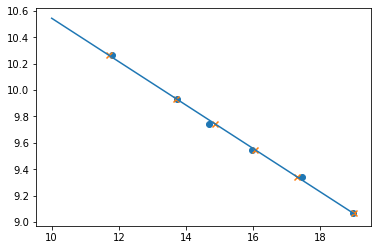

In [142]:
Se_arr = np.array([])

for i in range(l):
    Se_temp = S_e(a_ar[i], b_ar[i], S_uts_est, S_100)
    Se_arr = np.append(Se_arr, Se_temp)
    
logN_line = range(10,20,1)
logS_line = (np.log(k_est) - logN_line)/m_est

plt.scatter( np.log(N), np.log(Se_arr))
#plt.scatter( np.log(N_ver), np.log(Se_ver_arr), marker = 'x'label = 'Ver' )
plt.scatter( np.log(N_pred), np.log(Se_ver_arr),marker = 'x')
plt.plot(logN_line,logS_line)